In [30]:

import os, math, time, random, json
from typing import Tuple, Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd


seed = 2319
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = (
    torch.device('cuda') if torch.cuda.is_available() else (
    torch.device('mps') if getattr(torch.backends, 'mps', None) and torch.backends.mps.is_available() else
    torch.device('cpu'))
)
print('Using device:', device)

Using device: mps


In [31]:
transform = transforms.Compose([
    transforms.ToTensor(),  # scales to [0,1]
])

train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=50, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=50, shuffle=False)
len(train_ds), len(test_ds)

(60000, 10000)

In [33]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=0)  # -> 28-5+1=24
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0) # after pool: 12 -> conv -> 8
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(64 * 4 * 4, 1024)  # verify below
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        # x: (N,1,28,28)
        x = F.relu(self.conv1(x))          # (N,32,24,24)
        x = F.max_pool2d(x, 2)             # (N,32,12,12)
        x = F.relu(self.conv2(x))          # (N,64,8,8)
        x = F.max_pool2d(x, 2)             # (N,64,4,4)
        x = torch.flatten(x, 1)            # (N,64*4*4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)

In [34]:
def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()


def evaluate(model, loader, device):
    model.eval()
    total_loss, total_acc, total_n = 0.0, 0.0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            bs = x.size(0)
            total_loss += loss.item() * bs
            total_acc += (logits.argmax(1) == y).float().sum().item()
            total_n += bs
    return total_loss / total_n, total_acc / total_n


def train_baseline(
    model,
    train_loader,
    test_loader,
    device,
    max_steps: int = 100000,
    lr: float = 1e-4,
    log_every: int = 1000,
    eval_every: int = 1000,
    early_stop_patience: int = 10,
):
    """Natural training on MNIST with Adam and CrossEntropy."""
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    step = 0
    epoch = 0
    best_test_acc = 0.0
    no_improve_evals = 0
    history = []

    while step < max_steps:
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
            step += 1

            if step % log_every == 0:
                acc = accuracy(logits, y)
                print(f"step {step} | loss {loss.item():.4f} | acc {acc:.3f}")

            if step % eval_every == 0:
                test_loss, test_acc = evaluate(model, test_loader, device)
                history.append({'step': step, 'test_loss': test_loss, 'test_acc': test_acc})
                print(f"[eval] step {step} | test_loss {test_loss:.4f} | test_acc {test_acc:.3f}")

                # Early stopping and checkpointing on test accuracy
                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    no_improve_evals = 0
                    torch.save(model.state_dict(), 'baseline_mnist_CNN.pt')
                    print(f"[checkpoint] New best test_acc={best_test_acc:.3f} at step {step}. Model saved.")
                else:
                    no_improve_evals += 1
                    print(f"[early-stop] no improvement for {no_improve_evals}/{early_stop_patience} evaluations.")
                    if no_improve_evals >= early_stop_patience:
                        print(
                            f"[early-stop] Stopping at step {step}. Best test_acc={best_test_acc:.3f}"
                        )
                        return history

            if step >= max_steps:
                break
        epoch += 1
    return history



def train_FGSM(
    model,
    train_loader,
    test_loader,
    device,
    max_steps: int = 100000,
    lr: float = 1e-4,
    log_every: int = 1000,
    eval_every: int = 1000,
    early_stop_patience: int = 10,
    epsilon: float = 0.3,
):
    """FGSM adversarial training on MNIST with a single gradient step per batch."""
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    step = 0
    epoch = 0
    best_test_acc = 0.0
    no_improve_evals = 0
    history = []

    while step < max_steps:
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            # random start within L_inf ball
            noise = torch.empty_like(x).uniform_(-epsilon, epsilon)
            x_adv = (x + noise).clamp(0.0, 1.0)

            # Craft FGSM adversary in eval mode, then restore mode
            prev_mode = model.training
            model.eval()
            x_adv.requires_grad_(True)
            logits = model(x_adv)
            loss = criterion(logits, y)
            grad_x, = torch.autograd.grad(loss, x_adv, retain_graph=False, create_graph=False)

            with torch.no_grad():
                # one FGSM step from current x_adv (preserves random start)
                x_adv = x_adv + epsilon * grad_x.sign()
                # Project back to the L_inf ball around x and clamp to [0,1]
                x_adv = torch.max(torch.min(x_adv, x + epsilon), x - epsilon).clamp(0.0, 1.0)
            model.train(prev_mode)

            # Train on adversarial examples
            logits_adv = model(x_adv)
            loss_adv = criterion(logits_adv, y)
            optimizer.zero_grad(set_to_none=True)
            loss_adv.backward()
            optimizer.step()
            step += 1

            if step % log_every == 0:
                acc = accuracy(logits_adv, y)
                print(f"step {step} | loss_adv {loss_adv.item():.4f} | acc {acc:.3f}")

            if step % eval_every == 0:
                test_loss, test_acc = evaluate(model, test_loader, device)
                history.append({'step': step, 'test_loss': test_loss, 'test_acc': test_acc})
                print(f"[eval] step {step} | test_loss {test_loss:.4f} | test_acc {test_acc:.3f}")

                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    no_improve_evals = 0
                    torch.save(model.state_dict(), 'fgsm_mnist_CNN.pt')
                    print(f"[checkpoint] New best test_acc={best_test_acc:.3f} at step {step}. Model saved.")
                else:
                    no_improve_evals += 1
                    print(f"[early-stop] no improvement for {no_improve_evals}/{early_stop_patience} evaluations.")
                    if no_improve_evals >= early_stop_patience:
                        print(f"[early-stop] Stopping at step {step}. Best test_acc={best_test_acc:.3f}")
                        return history

            if step >= max_steps:
                break
        epoch += 1
    return history



def train_TRADES(
    model,
    train_loader,
    test_loader,
    device,
    max_steps: int = 100000,
    lr: float = 1e-4,
    log_every: int = 1000,
    eval_every: int = 1000,
    early_stop_patience: int = 10,
    epsilon: float = 0.3,
    beta: float = 6.0,
):
    """TRADES training with one-step KL-FGSM inner maximization."""
    
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ce_criterion = nn.CrossEntropyLoss()

    step = 0
    epoch = 0
    best_test_acc = 0.0
    no_improve_evals = 0
    history = []

    while step < max_steps:
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            # 1) Clean forward for CE term and to get target distribution p(x)
            logits_clean = model(x)
            ce = ce_criterion(logits_clean, y)
            with torch.no_grad():
                p_clean = F.softmax(logits_clean, dim=1)  # target distribution (detached)

            # 2) One-step KL-FGSM inner maximization to craft x_adv
            prev_mode = model.training
            model.eval()
            x_adv = x.detach().clone()
            x_adv = (x_adv + 0.001 * torch.randn_like(x_adv)).clamp(0.0, 1.0)
            x_adv.requires_grad_(True)
            logits_adv_for_grad = model(x_adv)
            log_q = F.log_softmax(logits_adv_for_grad, dim=1)
            kl_for_grad = F.kl_div(log_q, p_clean, reduction='batchmean')
            grad_x, = torch.autograd.grad(kl_for_grad, x_adv, retain_graph=False, create_graph=False)
            with torch.no_grad():
                # one KL-FGSM step from current x_adv (preserves random start)
                x_adv = x_adv + epsilon * grad_x.sign()
                # Project to L_inf-ball around x and clamp to valid range
                x_adv = torch.max(torch.min(x_adv, x + epsilon), x - epsilon)
                x_adv = x_adv.clamp(0.0, 1.0)
            model.train(prev_mode)

            # 3) Compute TRADES loss
            logits_adv = model(x_adv)
            log_q_adv = F.log_softmax(logits_adv, dim=1)
            kl = F.kl_div(log_q_adv, p_clean, reduction='batchmean')
            loss = ce + beta * kl

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
            step += 1

            if step % log_every == 0:
                acc_clean = accuracy(logits_clean, y)
                print(
                    f"step {step} | loss {loss.item():.4f} (CE {ce.item():.4f} + {beta}*KL {kl.item():.4f}) | acc_clean {acc_clean:.3f}"
                )

            if step % eval_every == 0:
                test_loss, test_acc = evaluate(model, test_loader, device)
                history.append({'step': step, 'test_loss': test_loss, 'test_acc': test_acc})
                print(f"[eval] step {step} | test_loss {test_loss:.4f} | test_acc (clean) {test_acc:.3f}")

                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    no_improve_evals = 0
                    torch.save(model.state_dict(), 'trades_mnist_CNN.pt')
                    print(f"[checkpoint] New best test_acc={best_test_acc:.3f} at step {step}. Model saved.")
                else:
                    no_improve_evals += 1
                    print(f"[early-stop] no improvement for {no_improve_evals}/{early_stop_patience} evaluations.")
                    if no_improve_evals >= early_stop_patience:
                        print(f"[early-stop] Stopping at step {step}. Best test_acc={best_test_acc:.3f}")
                        return history

            if step >= max_steps:
                break
        epoch += 1
    return history

In [16]:
# Let's do the Baseline Training
history = train_baseline(
    model,
    train_loader,
    test_loader,
    device,
    max_steps=100000,
    lr=1e-4,
    log_every=1000,
    eval_every=1000,
    early_stop_patience=5,
)

step 1000 | loss 0.0862 | acc 0.980
[eval] step 1000 | test_loss 0.1151 | test_acc 0.966
[checkpoint] New best test_acc=0.966 at step 1000. Model saved.
step 2000 | loss 0.0287 | acc 1.000
[eval] step 2000 | test_loss 0.0627 | test_acc 0.981
[checkpoint] New best test_acc=0.981 at step 2000. Model saved.
step 3000 | loss 0.0136 | acc 1.000
[eval] step 3000 | test_loss 0.0510 | test_acc 0.984
[checkpoint] New best test_acc=0.984 at step 3000. Model saved.
step 4000 | loss 0.0129 | acc 1.000
[eval] step 4000 | test_loss 0.0460 | test_acc 0.985
[checkpoint] New best test_acc=0.985 at step 4000. Model saved.
step 5000 | loss 0.0046 | acc 1.000
[eval] step 5000 | test_loss 0.0377 | test_acc 0.988
[checkpoint] New best test_acc=0.988 at step 5000. Model saved.
step 6000 | loss 0.0136 | acc 1.000
[eval] step 6000 | test_loss 0.0339 | test_acc 0.989
[checkpoint] New best test_acc=0.989 at step 6000. Model saved.
step 7000 | loss 0.0188 | acc 0.980
[eval] step 7000 | test_loss 0.0269 | test_acc

In [17]:
fgsm_training = train_FGSM(
    model,
    train_loader,
    test_loader,
    device,
    max_steps=100000,
    lr=1e-4,
    log_every=1000,
    eval_every=1000,
    early_stop_patience=5,
    epsilon=0.3,
)

step 1000 | loss_adv 1.2827 | acc 0.540
[eval] step 1000 | test_loss 0.1434 | test_acc 0.978
[checkpoint] New best test_acc=0.978 at step 1000. Model saved.
step 2000 | loss_adv 0.6142 | acc 0.820
[eval] step 2000 | test_loss 0.1173 | test_acc 0.980
[checkpoint] New best test_acc=0.980 at step 2000. Model saved.
step 3000 | loss_adv 0.6797 | acc 0.740
[eval] step 3000 | test_loss 0.0939 | test_acc 0.980
[checkpoint] New best test_acc=0.980 at step 3000. Model saved.
step 4000 | loss_adv 0.7162 | acc 0.760
[eval] step 4000 | test_loss 0.0752 | test_acc 0.983
[checkpoint] New best test_acc=0.983 at step 4000. Model saved.
step 5000 | loss_adv 0.5950 | acc 0.720
[eval] step 5000 | test_loss 0.0682 | test_acc 0.984
[checkpoint] New best test_acc=0.984 at step 5000. Model saved.
step 6000 | loss_adv 0.5986 | acc 0.740
[eval] step 6000 | test_loss 0.0592 | test_acc 0.984
[checkpoint] New best test_acc=0.984 at step 6000. Model saved.
step 7000 | loss_adv 0.3915 | acc 0.900
[eval] step 7000 |

In [18]:
# Train with TRADES
trades_history = train_TRADES(
    model,
    train_loader,
    test_loader,
    device,
    max_steps=100000,
    lr=1e-4,
    log_every=1000,
    eval_every=1000,
    early_stop_patience=5,
    epsilon=0.3,
    beta=6.0,
)

step 1000 | loss 1.0231 (CE 0.0167 + 6.0*KL 0.1677) | acc_clean 1.000
[eval] step 1000 | test_loss 0.0364 | test_acc (clean) 0.989
[checkpoint] New best test_acc=0.989 at step 1000. Model saved.
step 2000 | loss 0.2678 (CE 0.0084 + 6.0*KL 0.0432) | acc_clean 1.000
[eval] step 2000 | test_loss 0.0251 | test_acc (clean) 0.992
[checkpoint] New best test_acc=0.992 at step 2000. Model saved.
step 3000 | loss 0.1672 (CE 0.0012 + 6.0*KL 0.0277) | acc_clean 1.000
[eval] step 3000 | test_loss 0.0234 | test_acc (clean) 0.993
[checkpoint] New best test_acc=0.993 at step 3000. Model saved.
step 4000 | loss 0.0710 (CE 0.0002 + 6.0*KL 0.0118) | acc_clean 1.000
[eval] step 4000 | test_loss 0.0249 | test_acc (clean) 0.992
[early-stop] no improvement for 1/5 evaluations.
step 5000 | loss 0.6445 (CE 0.0039 + 6.0*KL 0.1068) | acc_clean 1.000
[eval] step 5000 | test_loss 0.0220 | test_acc (clean) 0.993
[early-stop] no improvement for 2/5 evaluations.
step 6000 | loss 0.5937 (CE 0.0034 + 6.0*KL 0.0984) | a

Plotting the results

In [19]:
from collections import OrderedDict


def fgsm_attack(model, x, y, epsilon):
    """Craft FGSM adversarial examples for the given model and inputs.
    Returns perturbed inputs x_adv. White-box: uses gradients of the provided model.
    """
    prev = model.training
    model.eval()
    x_adv = x.clone().detach().requires_grad_(True)
    logits = model(x_adv)
    loss = F.cross_entropy(logits, y)
    grad_x, = torch.autograd.grad(loss, x_adv, retain_graph=False, create_graph=False)
    with torch.no_grad():
        x_adv = (x_adv + epsilon * grad_x.sign()).clamp(0.0, 1.0)
    model.train(prev)
    return x_adv.detach()


def evaluate_under_fgsm(model, loader, epsilon, device):
    """Evaluate model accuracy under a white-box FGSM attack with budget epsilon."""
    model.eval()
    total = 0
    correct = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        x_adv = x if epsilon == 0 else fgsm_attack(model, x, y, epsilon)
        with torch.no_grad():
            logits_adv = model(x_adv)
            pred = logits_adv.argmax(1)
        correct += (pred == y).float().sum().item()
        total += x.size(0)
    return correct / total

In [20]:
# Load saved models and run FGSM sweep
def load_model_from_ckpt(path, device):
    m = CNN().to(device)
    state = torch.load(path, map_location=device)
    m.load_state_dict(state)
    return m.eval()

epsilons = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
model_paths = OrderedDict({
    'Baseline': 'baseline_mnist_CNN.pt',
    'FGSM-trained': 'fgsm_mnist_CNN.pt',
    'TRADES': 'trades_mnist_CNN.pt',
})

results = []
for name, ckpt in model_paths.items():
    mdl = load_model_from_ckpt(ckpt, device)
    for eps in epsilons:
        acc = evaluate_under_fgsm(mdl, test_loader, epsilon=eps, device=device)
        results.append({'model': name, 'epsilon': eps, 'acc': acc})
        print(f"{name:12s} | eps={eps:.1f} | acc={acc:.4f}")

df = pd.DataFrame(results)
display(df)

/var/folders/tp/n7w37fnn7wscxyzx0rk621g80000gn/T/ipykernel_59382/46299819.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, map_location=device)


Baseline     | eps=0.0 | acc=0.9929
Baseline     | eps=0.1 | acc=0.8647
Baseline     | eps=0.2 | acc=0.3588
Baseline     | eps=0.3 | acc=0.0937
Baseline     | eps=0.4 | acc=0.0348
Baseline     | eps=0.5 | acc=0.0175
Baseline     | eps=0.6 | acc=0.0169
Baseline     | eps=0.7 | acc=0.0246
FGSM-trained | eps=0.0 | acc=0.9923
FGSM-trained | eps=0.1 | acc=0.9735
FGSM-trained | eps=0.2 | acc=0.9448
FGSM-trained | eps=0.3 | acc=0.9123
FGSM-trained | eps=0.4 | acc=0.8465
FGSM-trained | eps=0.5 | acc=0.6231
FGSM-trained | eps=0.6 | acc=0.3565
FGSM-trained | eps=0.7 | acc=0.2125
TRADES       | eps=0.0 | acc=0.9932
TRADES       | eps=0.1 | acc=0.9754
TRADES       | eps=0.2 | acc=0.9464
TRADES       | eps=0.3 | acc=0.8941
TRADES       | eps=0.4 | acc=0.6892
TRADES       | eps=0.5 | acc=0.3728
TRADES       | eps=0.6 | acc=0.2091
TRADES       | eps=0.7 | acc=0.1425


,model,epsilon,acc
0,Baseline,0.0,0.9929
1,Baseline,0.1,0.8647
2,Baseline,0.2,0.3588
3,Baseline,0.3,0.0937
4,Baseline,0.4,0.0348
5,Baseline,0.5,0.0175
6,Baseline,0.6,0.0169
7,Baseline,0.7,0.0246
8,FGSM-trained,0.0,0.9923
9,FGSM-trained,0.1,0.9735


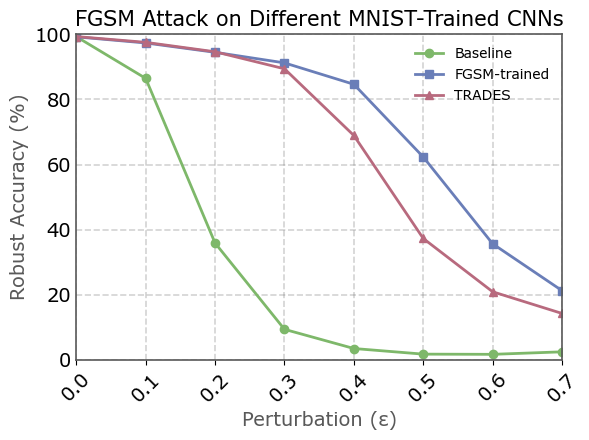

In [ ]:
# Styled plot: Accuracy vs epsilon (FGSM)
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Verdana'],
    'axes.titlesize': 15,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})

# Colors (allow override via globals)
_baseline_color = globals().get('baseline_color', '#7EB86A')
_fgsm_color     = globals().get('fgsm_color',     '#6A7EB8')
_trades_color   = globals().get('trades_color',   '#B86A7E')

def _style_axes(ax):
    ax.grid(True, linestyle='--', color='gray', alpha=0.35, linewidth=1.2)
    for side in ['left', 'bottom', 'top', 'right']:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_color('#595959')
        ax.spines[side].set_linewidth(1.2)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14, which='both', length=0)

styles = {
    'Baseline':      dict(color=_baseline_color, marker='o', linestyle='-', linewidth=2, markersize=6, label='Baseline'),
    'FGSM-trained':  dict(color=_fgsm_color,     marker='s', linestyle='-', linewidth=2, markersize=6, label='FGSM-trained'),
    'TRADES':        dict(color=_trades_color,   marker='^', linestyle='-', linewidth=2, markersize=6, label='TRADES'),
}

fig, ax = plt.subplots(figsize=(6, 4.5))
for name in model_paths.keys():
    sub = df[df['model'] == name].sort_values('epsilon')
    x = list(sub['epsilon'])
    y = list(sub['acc'] * 100.0)
    if len(x) > 0:
        ax.plot(x, y, **styles[name])

ax.set_xlabel('Perturbation (ε)', color='#595959')
ax.set_ylabel('Robust Accuracy (%)', color='#595959')
ax.set_title('FGSM Attack on Different MNIST-Trained CNNs')
_style_axes(ax)
ax.legend(loc='best', frameon=False)
ax.set_xticks(epsilons)
ax.set_xlim(min(epsilons), max(epsilons))
ax.set_ylim(0, 100)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('fgsm_accuracy_vs_epsilon.pdf', dpi=300)
plt.show()

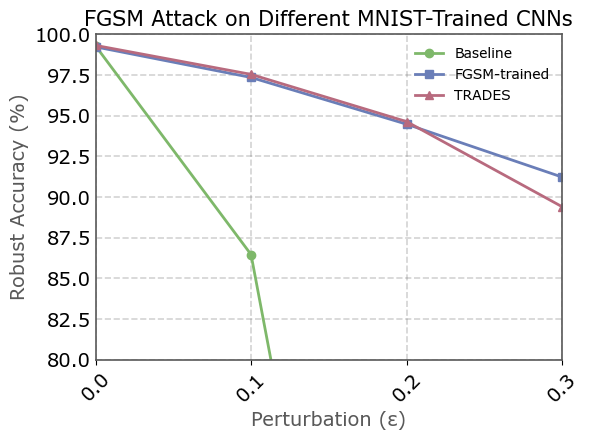

In [ ]:
# Styled plot: Accuracy vs epsilon (FGSM)
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Verdana'],
    'axes.titlesize': 15,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})

# Colors (allow override via globals)
_baseline_color = globals().get('baseline_color', '#7EB86A')
_fgsm_color     = globals().get('fgsm_color',     '#6A7EB8')
_trades_color   = globals().get('trades_color',   '#B86A7E')

def _style_axes(ax):
    ax.grid(True, linestyle='--', color='gray', alpha=0.35, linewidth=1.2)
    for side in ['left', 'bottom', 'top', 'right']:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_color('#595959')
        ax.spines[side].set_linewidth(1.2)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14, which='both', length=0)

styles = {
    'Baseline':      dict(color=_baseline_color, marker='o', linestyle='-', linewidth=2, markersize=6, label='Baseline'),
    'FGSM-trained':  dict(color=_fgsm_color,     marker='s', linestyle='-', linewidth=2, markersize=6, label='FGSM-trained'),
    'TRADES':        dict(color=_trades_color,   marker='^', linestyle='-', linewidth=2, markersize=6, label='TRADES'),
}

fig, ax = plt.subplots(figsize=(6, 4.5))
for name in model_paths.keys():
    sub = df[df['model'] == name].sort_values('epsilon')
    x = list(sub['epsilon'])
    y = list(sub['acc'] * 100.0)
    if len(x) > 0:
        ax.plot(x, y, **styles[name])

ax.set_xlabel('Perturbation (ε)', color='#595959')
ax.set_ylabel('Robust Accuracy (%)', color='#595959')
ax.set_title('FGSM Attack on Different MNIST-Trained CNNs')
_style_axes(ax)
ax.legend(loc='best', frameon=False)
ax.set_xticks(epsilons)
ax.set_xlim(min(epsilons), 0.3)
ax.set_ylim(80, 100)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('fgsm_accuracy_vs_epsilon-zoom.pdf', dpi=300)
plt.show()